In [ ]:
from textblob import TextBlob
import pandas as pd
import datetime as dt
import numpy as np
import re

In [ ]:
path="data/"
search_word_list=["palantir","Tesla"]
search_word=search_word_list[1]

start_date="2016-01-01"
last_date="2022-05-24"

In [ ]:
def concat_twitter_dat(path, search_word, start_date, last_date):
    results = pd.DataFrame([])
    for date in pd.date_range(start=start_date, end=last_date):
        results = results.append(pd.read_csv(path +
                                            search_word +
                                            "_" +
                                            date.strftime('%Y-%m-%d') + ".csv", index_col=0, parse_dates=["date"]))
    return results.reset_index(drop=True)

concat_data=concat_twitter_dat(path,search_word,start_date,last_date)

In [ ]:
def cleanUpTweet(txt):
    txt = re.sub(r'@[A-Za-z0-9_]+', '', txt)
    txt = re.sub(r'#', '', txt)
    txt = re.sub(r'RT : ', '', txt)
    txt = re.sub(r'https?:|/|/[A-Za-z0-9\.\/]+', '', txt)
    return txt
cleand_data=concat_data
cleand_data["text"]=concat_data["text"].apply(cleanUpTweet)

In [ ]:

def getTextSubjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def getTextPolarity(txt):
    return TextBlob(txt).sentiment.polarity

def getTextAnalysis(a):
    if a < 0:
        return "Negative"
    elif a == 0:
        return "Neutral"
    else:
        return "Positive"

def emotiontDataAdd(twitter_data):
    results = twitter_data.copy()
    results['clean_text'] = results['text'].apply(cleanUpTweet)
    results["polarity"] = results['clean_text'].apply(getTextPolarity)
    results["subjectivity"] = results['clean_text'].apply(getTextSubjectivity)
    results["emotion"] = results['polarity'].apply(getTextAnalysis)
    
    return results

prepare_data=emotiontDataAdd(cleand_data)
prepare_data["date"]=prepare_data["date"].dt.tz_localize(None)



In [ ]:
def convertDateType(stock_data):
    results = stock_data.copy()
    results["Date"] = results.index.tz_convert('UTC')
    results["Date"] = results["Date"].dt.tz_localize(None)
    results = results.reset_index(drop=True)
    return results

interval="1D"

stock_data=pd.read_csv(path +"stock_" + start_date + "_" + last_date  + "_"+ interval + ".csv")

stock_data["Date"]=pd.to_datetime(stock_data["Date"],utc=True)
stock_data.set_index('Date',drop=False, inplace=True)


stock_data=convertDateType(stock_data)
#stock_data.set_index('date',drop=False, inplace=True)
#stock_data=stock_data.drop(["Unnamed: 0"],axis=1)



In [ ]:
# from tsfresh import extract_features, extract_relevant_features, select_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_extraction import ComprehensiveFCParameters
# extraction_settings = ComprehensiveFCParameters()

# X = extract_features(df, column_id='id', column_sort='time',
#                      default_fc_parameters=extraction_settings,
#                      # we impute = remove all NaN features automatically
#                      impute_function=impute)
# X_filtered = select_features(X, y)

In [ ]:


    
def add_twitter_variables(stock_data,
                         twitter_data,
                         tweet_lag=60,
                         subset_tweets_per=1):

    interval = int((stock_data["Date"][1] - stock_data["Date"][0]).seconds / 60)
    

    results = stock_data.copy()
    results["tw_count"] = pd.NA     # number of tweets per interval
    results["tw_mean"] = pd.NA      # mean of number of tweets per subset_twets_per in interval
    results["tw_vola"] = pd.NA      # volatility of number of tweets per subset_tweets_per in interval
    results["tw_min"] = pd.NA       # min number of tweets per subset_tweets_per in interval
    results["tw_max"] = pd.NA       # max number of tweets per subset_tweets_per in interval
    results["tw_pola"] =pd.NA      # avg polarity of tweets
    results["tw_subj"] = pd.NA     # avg subjectivity of tweets
    results["tw_n_pos"] = pd.NA     # number of positive tweets
    results["tw_n_neg"] = pd.NA     # number of negative tweets
    results["tw_ratio_pos"] =pd.NA # share of positive tweets
    results["tw_ratio_neg"] = pd.NA # share of negative tweets
    

    for i in range(0, stock_data.shape[0]):
        current_time = stock_data.loc[i,"Date"]
        
        cond_1 = twitter_data["date"] < (current_time + dt.timedelta(minutes=interval - tweet_lag))
        cond_2 = twitter_data["date"] >= (current_time - dt.timedelta(minutes=tweet_lag))
        
        twitter_subset = twitter_data.loc[cond_1 & cond_2, :].copy().reset_index(drop=True)
        
        results.loc[i, "tw_count"] = twitter_subset.shape[0]
        

        tweets_per = pd.Series(np.zeros(interval))
        for x in np.arange(subset_tweets_per, interval + 1, subset_tweets_per):
            sub_cond_1 = twitter_subset["date"] >= (current_time + dt.timedelta(minutes=(int(x) - 1 - tweet_lag)))
            sub_cond_2 = twitter_subset["date"] < (current_time + dt.timedelta(minutes=(int(x) - tweet_lag)))
            tweets_per[x - 1] = twitter_subset.loc[sub_cond_1 & sub_cond_2, :].shape[0]
            
        # Compute Variables "tw_mean", "tw_vola", "tw_min", "tw_max"
        results.loc[i, "tw_mean"] = tweets_per.mean()
        results.loc[i, "tw_vola"] = tweets_per.var()
        results.loc[i, "tw_min"] = tweets_per.min()
        results.loc[i, "tw_max"] = tweets_per.max()
        

        # Content related variables
        results.loc[i, "tw_pola"] = twitter_subset["polarity"].mean()
        results.loc[i, "tw_subj"] = twitter_subset["subjectivity"].mean()
        results.loc[i, "tw_n_pos"] = twitter_subset.loc[twitter_subset.emotion == "Positive", :]
        results.loc[i, "tw_n_neg"] = twitter_subset.loc[twitter_subset.emotion == "Negative", :]
        if twitter_subset.shape[0]!=0:
            results.loc[i, "tw_ratio_pos"] = results.loc[i, "tw_n_pos"] / twitter_subset.shape[0]
            results.loc[i, "tw_ratio_neg"] = results.loc[i, "tw_n_neg"] / twitter_subset.shape[0]
        
    return results
variables_data=add_twitter_variables(stock_data,prepare_data)
variables_data=variables_data.fillna(0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


#variables_data["date"]=variables_data["date"].values.astype("float64")
variables_data=variables_data.drop(["Date"],axis=1)
#variables_data=variables_data.drop(["date"],axis=1)
print(variables_data.columns)

def makePersent(data):
    result = data.copy()
    for i in range(1,data.shape[0]):
        result.loc[i,"Open"]=(data.loc[i,"Open"]-data.loc[i-1,"Close"])/data.loc[i-1,"Close"] *100
        result.loc[i,"High"]=(data.loc[i,"High"]-data.loc[i-1,"Close"])/data.loc[i-1,"Close"] *100
        result.loc[i,"Low"]=(data.loc[i,"Low"]-data.loc[i-1,"Close"])/data.loc[i-1,"Close"] *100
        result.loc[i,"Close"]=(data.loc[i,"Close"]-data.loc[i-1,"Close"])/data.loc[i-1,"Close"] *100
        result.loc[i,"Adj Close"]=(data.loc[i,"Adj Close"]-data.loc[i-1,"Adj Close"])/data.loc[i-1,"Adj Close"] *100
        
        result.loc[i,"Volume"]=(data.loc[i,"Volume"]-data.loc[i-1,"Volume"])/data.loc[i-1,"Volume"] *100
        
    return result
        
    
    
persent_data_data=makePersent(variables_data)

# first volume of yfinace data is always 0. so second volume persent is inf. remove two row
#sometimes last row have current date. not target date
variables_data=persent_data_data.drop([persent_data_data.index[0]],axis=0)
variables_data=variables_data.drop([variables_data.index[0]],axis=0)
variables_data=variables_data.drop([variables_data.index[-1]],axis=0)
variables_data=variables_data.reset_index(drop=True)


In [ ]:
#scale
scaler = MinMaxScaler()
variables_data[["tw_count","tw_mean","tw_vola","tw_min","tw_max"]]=scaler.fit_transform(variables_data[["tw_count","tw_mean","tw_vola","tw_min","tw_max"]])
only_stock_data_training = variables_data.iloc[:, 0:6].copy()

train_set, test_set = train_test_split(variables_data, test_size = 0.3,shuffle=False)
only_stock_train_set, only_stock_test_set = train_test_split(only_stock_data_training, test_size = 0.3,shuffle=False)

In [ ]:
from tensorflow.keras import Sequential
from keras.models import load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
import tensorflow as tf
import keras.backend as K
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras.callbacks import ModelCheckpoint

In [ ]:
def makeLSTMDataSet(data_training,data_test
                    ,step_size = 5):
    train_data = []
    target_data = []

    for i in range(step_size, data_training.shape[0]):
        train_data.append(data_training.loc[i - step_size:i-1])
        target_data.append(data_training.loc[i, "Close"])
    train_data, target_data = np.array(train_data), np.array(target_data)

    #test data
    test_train_data = []
    test_target_data = []
    
    data_test=data_test.reset_index(drop=True)
    for i in range(step_size, data_test.shape[0]):
        test_train_data.append(data_test.loc[i - step_size:i-1])
        test_target_data.append(data_test.loc[i, "Close"])
    test_train_data, test_target_data = np.array(test_train_data), np.array(test_target_data)
    
    return train_data, target_data, test_train_data, test_target_data


train_data, target_data, test_train_data, test_target_data=makeLSTMDataSet(train_set, test_set)
only_stock_train_data, only_stock_target_data, only_stock_test_train_data, only_stock_test_target_data=makeLSTMDataSet(only_stock_train_set, only_stock_test_set)

In [ ]:
#  Create  Model
def model_wrapper_get_input_size(input_data):
    def build_model(hp):
        model = Sequential()
        
        hidden = hp.Int("num_layers",
                    min_value = 0,
                    max_value = 3)
        activations = hp.Choice("activation",
                                        values = ["relu", "tanh", "sigmoid"],
                                        default = "relu")
        model.add(LSTM(units = hp.Int("units",
                                    min_value = 18,
                                    max_value = 128,
                                    step = 32),
                    activation = activations,
                    input_shape = (input_data.shape[1], input_data.shape[2]),
                    return_sequences = True if hidden > 0 else False))
        
        if hidden > 0:
            for layer in range(hidden):
                model.add(Dropout(hp.Float("dropout_hidden" + str(layer + 1),
                                        min_value = 0.1,
                                        max_value = 0.9,
                                        step = 0.1)))
                
                model.add(LSTM(units = hp.Int("units_hidden" + str(layer + 1),
                                            min_value = 18,
                                            max_value = 64,
                                            step = 32),
                            activation = activations,
                            return_sequences = True if layer+1 != hidden else False))
                
        model.add(Dropout(hp.Float("dropout",
                                min_value = 0.1,
                                max_value = 0.9,
                                step = 0.1)))
        model.add(Dense(units = 1))
        
        hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
        model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                        loss = 'mean_squared_error')
            
        return model
    return build_model



In [ ]:
def getBestModel(trainData,targetData,projectName="recommend_stock"):
    tuner = RandomSearch(model_wrapper_get_input_size(trainData),
                        objective = 'loss',
                        max_trials = 10,
                        executions_per_trial = 2,
                        overwrite=False,
                        directory = "model_store",
                        project_name=projectName,)




    early_stopping_cb = EarlyStopping(monitor='loss',patience = 10)

    tuner.search(trainData,
                targetData,
                epochs = 100,
                batch_size = 32,
                validation_split = 0.2,
                callbacks = [early_stopping_cb])

    best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]



    best_model = tuner.hypermodel.build(best_hps)

    print(f"""
    The hyperparameter search is complete. The optimal number of units in the first densely-connected
    layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
    is {best_hps.get('learning_rate')}.
    """)
    return best_model

In [71]:
best_model=getBestModel(train_data,target_data,"recommend_stock")
best_model.fit(train_data, target_data, epochs = 1000, validation_data = (test_train_data, test_target_data))
best_model.save("best_model.h5")

35/35 [==============================] - 0s 9ms/step - loss: 8.8600 - val_loss: 18.3345
Epoch 251/1000
35/35 [==============================] - 0s 8ms/step - loss: 8.5033 - val_loss: 18.3451
Epoch 252/1000
35/35 [==============================] - 0s 8ms/step - loss: 8.4679 - val_loss: 18.3671
Epoch 253/1000
35/35 [==============================] - 0s 8ms/step - loss: 8.3251 - val_loss: 18.3632
Epoch 254/1000
35/35 [==============================] - 0s 8ms/step - loss: 8.4893 - val_loss: 18.3889
Epoch 255/1000
35/35 [==============================] - 0s 7ms/step - loss: 8.3165 - val_loss: 18.3889
Epoch 256/1000
35/35 [==============================] - 0s 8ms/step - loss: 8.6412 - val_loss: 18.4032
Epoch 257/1000
35/35 [==============================] - 0s 8ms/step - loss: 8.4726 - val_loss: 18.4106
Epoch 258/1000
35/35 [==============================] - 0s 7ms/step - loss: 8.5466 - val_loss: 18.4299
Epoch 259/1000
35/35 [==============================] - 0s 7ms/step - loss: 8.3386 - val

In [72]:
only_stock_best_model=getBestModel(only_stock_train_data,only_stock_target_data,"only_stock_recommend_stock")
only_stock_best_model.fit(only_stock_train_data, only_stock_target_data, epochs = 1000, validation_data = (only_stock_test_train_data, only_stock_test_target_data))
only_stock_best_model.save("only_stock_best_model.h5")


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
3                 |?                 |num_layers
tanh              |?                 |activation
18                |?                 |units
0.2               |?                 |dropout
0.0001            |?                 |learning_rate

Epoch 1/100
28/28 [==============================] - 9s 70ms/step - loss: 8.4373 - val_loss: 25.5596
Epoch 2/100
28/28 [==============================] - 0s 11ms/step - loss: 8.4426 - val_loss: 25.5589
Epoch 3/100
28/28 [==============================] - 0s 11ms/step - loss: 8.4410 - val_loss: 25.5560
Epoch 4/100
28/28 [==============================] - 0s 10ms/step - loss: 8.4423 - val_loss: 25.5509
Epoch 5/100
28/28 [==============================] - 0s 14ms/step - loss: 8.4351 - val_loss: 25.5494
Epoch 6/100
28/28 [==============================] - 0s 11ms/step - loss: 8.4427 - val_loss: 25.5435
Epoch 7/100
28/28 [==============================] - 0s 10ms/step - loss:

KeyboardInterrupt: 

In [74]:

def accOfUpDown(pred,real):
    #if same sign, multiply num is positive num
    isSame=pred*real
    isSame=isSame[isSame>0]
    return isSame.shape[0]/pred.shape[0]*100

def virtual_invest(pred,real):
    money=100
    isHave=False
    for i in range(0,pred.shape[0]):
        
        if money<0:
            return money
        
        if pred[i]<0:
            if(isHave):
                isHave=False
            else:
                pass
            
        elif pred[i]>0:
            if(isHave):
                money=money+money*real[i]/100
            else:
                isHave=True
                money=money+money*real[i]/100
    

    return money
from matplotlib import pyplot as plt
def plotXY(pred,real):
    plt.figure(figsize = (20, 10))
    plt.plot(pred)
    plt.plot(real)
    plt.title('Prediction vs Real Stock')
    plt.ylabel('ups and downs')
    plt.xlabel('Days')
    plt.legend(['Prediction', 'Real'], loc='best')
    
from sklearn.metrics import mean_squared_error
def printEval(model_name,test_target_data,test_train_data):
    saved_model = load_model(model_name, compile = False)
    print(saved_model)

    predict_test_train_data = saved_model.predict(test_train_data)
    predict_test_train_data = predict_test_train_data.flatten()

    error_lstm = mean_squared_error(test_target_data, predict_test_train_data)
    print("MSE Error is", error_lstm)

    upDownAcc=accOfUpDown(predict_test_train_data,test_target_data)
    print(upDownAcc,"%")

    virtual_money=virtual_invest(predict_test_train_data,test_target_data)
    print(virtual_money,"$")

    plotXY(predict_test_train_data,test_target_data)



MSE Error is 29.692547480289786
52.30125523012552 %
234.0262566419011 $


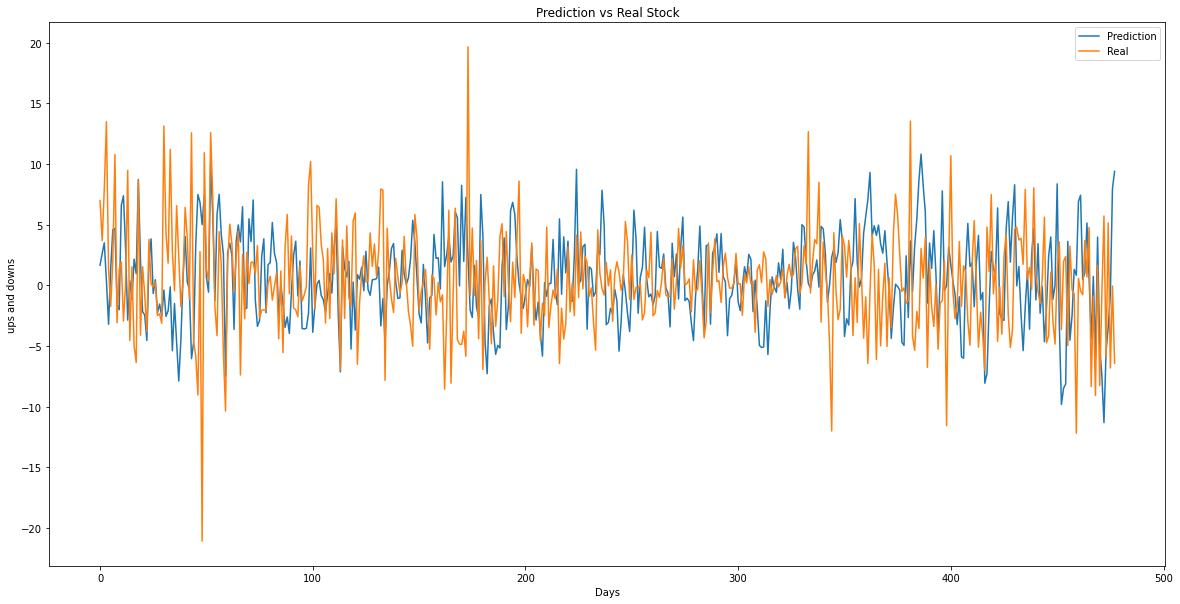

In [75]:

printEval('best_model.h5',test_target_data, test_train_data)

In [76]:

printEval('only_stock_best_model.h5',only_stock_test_target_data, only_stock_test_train_data)

OSError: No file or directory found at only_stock_best_model.h5